In [10]:
!pip install pymdptoolbox
!pip install torchrl

  Preparing metadata (setup.py) ... done
  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25656 sha256=6cc492c6d55b240dc4e57842ccb3560dd5f667ab296fc9224b0b1378fc7f8066
  Stored in directory: /root/.cache/pip/wheels/2b/e7/c7/d7abf9e309f3573a934fed2750c70bd75d9e9d901f7f16e183
Successfully built pymdptoolbox
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64

# Mining Environment

In [11]:
import mdptoolbox, mdptoolbox.example
import numpy as np
import enum
import random
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple
from torchrl.data import ListStorage, PrioritizedReplayBuffer
from torch.nn.utils import clip_grad_norm_
np.random.seed(42)
random.seed(42)

In [12]:
match_dict_inv = {0: 'irrelevant', 1: 'relevant', 2: 'active'}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
class State:
    def __init__(self, l_a, l_h, b_e, match="relevant"):
        self.length_a = l_a
        self.length_h = l_h
        self.blocks_e = b_e
        self.match = match
        self.match_dict = {'irrelevant': 0, 'relevant': 1, 'active': 2}


    def __hash__(self):
        return hash((self.length_a, self.length_h, self.blocks_e, self.match))

    def __eq__(self, other):
        try:
            return (self.length_a, self.length_h, self.blocks_e, self.match) == (other.length_a, other.length_h, other.blocks_e, other.match)
        except:
            return False

    def __ne__(self, other):
        return not (self == other)

    def __repr__(self):
        return "(%d, %d, %d, %s)" % (self.length_a, self.length_h, self.blocks_e, self.match)

    def to_numpy(self):
      return np.array([self.length_a, self.length_h, self.blocks_e, self.match_dict[self.match]])


In [14]:
class MiningEnv():

  def __init__(self, p, stale, gamma, cost, cutoff=20, lam=0):
    self.p = p
    self.cutoff = cutoff
    self.lam = lam
    self.match_cases = ["irrelevant", "relevant", "active"]
    self.a_cost = cost * p
    self.h_cost = cost * (1 - p)
    self.q = 1 - p - lam
    self.stale = stale
    self.gamma = gamma
    self.current_state = State(0, 0, 0, 'irrelevant')
    state_count = 0
    self.states = {}
    self.states_inverted = {}
    for l_a in range(self.cutoff + 1):
      for l_h in range(self.cutoff + 1):
        for b_e in range(l_a + 1):
          if self.lam == 0 and b_e > 0:
            continue
          for match in self.match_cases:
            state = State(l_a, l_h, b_e, match)
            self.states[state_count] = state
            self.states_inverted[state] = state_count
            state_count += 1
    self.states_counter = state_count

    # transition matrices
    P_adopt = np.zeros(shape=(state_count, state_count))
    P_override = np.zeros(shape=(state_count, state_count))
    P_match = np.zeros(shape=(state_count, state_count))
    P_wait = np.zeros(shape=(state_count, state_count))

    # reward matrices
    R_adopt = np.empty(shape=(state_count, state_count), dtype=object)
    R_override = np.empty(shape=(state_count, state_count), dtype=object)
    R_match = np.empty(shape=(state_count, state_count), dtype=object)
    R_wait = np.empty(shape=(state_count, state_count), dtype=object)

    R_adopt.fill((0,0))
    R_override.fill((0,0))
    R_match.fill((0,0))
    R_wait.fill((0,0))

    for state_idx, state in self.states.items():
      l_a = state.length_a
      l_h = state.length_h
      b_e = state.blocks_e
      match = state.match

      # adopt action transition matrix
      # attacker mines next block
      P_adopt[state_idx, self.states_inverted[State(1, 0, 0, "irrelevant")]] = self.p
      R_adopt[state_idx, self.states_inverted[State(1, 0, 0, "irrelevant")]] = (-self.a_cost, l_h - self.h_cost)

      # eclipsed node mines next block
      if self.lam != 0:
        P_adopt[state_idx, self.states_inverted[State(1, 0, 1, "irrelevant")]] = self.lam
        R_adopt[state_idx, self.states_inverted[State(1, 0, 1, "irrelevant")]] = (-self.a_cost, l_h - self.h_cost)

      # honest network mines next block
      P_adopt[state_idx, self.states_inverted[State(0, 1, 0, "relevant")]] = self.q*(1-self.stale)
      R_adopt[state_idx, self.states_inverted[State(0, 1, 0, "relevant")]] = (-self.a_cost, l_h - self.h_cost)

      # network mines state block
      P_adopt[state_idx, self.states_inverted[State(0, 0, 0, "irrelevant")]] = self.q * self.stale
      R_adopt[state_idx, self.states_inverted[State(0, 0, 0, "irrelevant")]] = (-self.a_cost, l_h - self.h_cost)

      # override action transition matrix
      if l_a > l_h:
        payout = (l_h+1)*(l_a - b_e)//l_a
        new_b_e = b_e - (l_h+1 - payout)
      # attacker mines next block
        P_override[state_idx, self.states_inverted[State(l_a - l_h, 0, new_b_e, "irrelevant")]] = self.p
        R_override[state_idx, self.states_inverted[State(l_a - l_h, 0, new_b_e, "irrelevant")]] = (payout - self.a_cost, b_e - new_b_e - self.h_cost)

      # eclipsed node mines next block
        if self.lam != 0:
          P_override[state_idx, self.states_inverted[State(l_a - l_h, 0, new_b_e + 1, "irrelevant")]] = self.lam
          R_override[state_idx, self.states_inverted[State(l_a - l_h, 0, new_b_e + 1, "irrelevant")]] = (payout - self.a_cost, b_e - new_b_e - self.h_cost)

      # network mines next block
        P_override[state_idx, self.states_inverted[State(l_a-l_h-1, 1, new_b_e, "relevant")]] = self.q*(1 - self.stale)
        R_override[state_idx, self.states_inverted[State(l_a-l_h-1, 1, new_b_e, "relevant")]] = (payout - self.a_cost, b_e - new_b_e - self.h_cost)

      # network mines stale block
        P_override[state_idx, self.states_inverted[State(l_a-l_h-1, 0, new_b_e, "irrelevant")]] = self.q*self.stale
        R_override[state_idx, self.states_inverted[State(l_a-l_h-1, 0, new_b_e, "irrelevant")]] = (payout - self.a_cost, b_e - new_b_e - self.h_cost)

      else:
        P_override[state_idx, state_idx] = 1
        R_override[state_idx, state_idx] = (-10, -10)

      # perform adopt and override after cutoff reached
      if l_a == self.cutoff or l_h == self.cutoff:
        P_match[state_idx, state_idx] = 1
        R_match[state_idx, state_idx] = (-10, -10)
        P_wait[state_idx, state_idx] = 1
        R_wait[state_idx, state_idx] = (-10, -10)
        continue


      # match action transition matrix
      if match == 'relevant' and l_a >= l_h and l_h > 0:
        payout = (l_h)*(l_a - b_e)//l_a
        new_b_e = b_e - (l_h - payout)

        # attacker mines next block
        P_match[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e, "active")]] = self.p
        R_match[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e, "active")]] =  (-self.a_cost, -self.h_cost)

        # eclipsed node mines next block
        if self.lam != 0:
          P_match[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e+1, "active")]] = self.lam
          R_match[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e+1, "active")]] = (-self.a_cost, -self.h_cost)

        # network mines next block after pool's head
        P_match[state_idx, self.states_inverted[State(l_a - l_h, 1, new_b_e, "relevant")]] = self.gamma * self.q * (1 - self.stale)
        R_match[state_idx, self.states_inverted[State(l_a - l_h, 1, new_b_e, "relevant")]] = (payout - self.a_cost, b_e - new_b_e - self.h_cost)

        # network mines next block after other's head
        P_match[state_idx, self.states_inverted[State(l_a, l_h + 1, b_e, "relevant")]] = (1-self.gamma) * self.q * (1 - self.stale)
        R_match[state_idx, self.states_inverted[State(l_a, l_h + 1, b_e, "relevant")]] = (-self.a_cost, -self.h_cost)

        # network mines stale block
        P_match[state_idx, self.states_inverted[State(l_a, l_h, b_e, "active")]] = self.q * self.stale
        R_match[state_idx, self.states_inverted[State(l_a, l_h, b_e, "active")]] = (-self.a_cost, -self.h_cost)
      else:
        P_match[state_idx, state_idx] = 1
        R_match[state_idx, state_idx] = (-10, -10)

      # wait action transition matrix
      if match == 'active' and l_a >= l_h and l_h > 0:
        payout = (l_h)*(l_a - b_e)//l_a
        new_b_e = b_e - (l_h - payout)

        # attacker mines next block
        P_wait[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e, "active")]] = self.p
        R_wait[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e, "active")]] = (-self.a_cost, -self.h_cost)

        # eclipsed node mines next block
        if self.lam != 0:
          P_wait[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e+1, "active")]] = self.lam
          R_wait[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e+1, "active")]] = (-self.a_cost, -self.h_cost)

        # network mines after the pool's head
        P_wait[state_idx, self.states_inverted[State(l_a - l_h, 1, new_b_e, "relevant")]] = self.gamma * self.q * (1 - self.stale)
        R_wait[state_idx, self.states_inverted[State(l_a - l_h, 1, new_b_e, "relevant")]] = (payout - self.a_cost, b_e - new_b_e - self.h_cost)

        # network mines after other's head
        P_wait[state_idx, self.states_inverted[State(l_a, l_h + 1, b_e, "relevant")]] = (1-self.gamma) * self.q * (1 - self.stale)
        R_wait[state_idx, self.states_inverted[State(l_a, l_h + 1, b_e, "relevant")]] = (-self.a_cost, -self.h_cost)

        # network mines stale block
        P_wait[state_idx, self.states_inverted[State(l_a, l_h, b_e, "active")]] = self.q * self.stale
        R_wait[state_idx, self.states_inverted[State(l_a, l_h, b_e, "active")]] = (-self.a_cost, -self.h_cost)

      else:
        # attacker mines next block
        P_wait[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e, "irrelevant")]] = self.p
        R_wait[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e, "irrelevant")]] = (-self.a_cost, -self.h_cost)

        # eclipsed node mines next block
        if self.lam != 0:
          P_wait[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e+1, "irrelevant")]] = self.lam
          R_wait[state_idx, self.states_inverted[State(l_a + 1, l_h, b_e+1, "irrelevant")]] = (-self.a_cost, -self.h_cost)

        # network mines next block
        P_wait[state_idx, self.states_inverted[State(l_a, l_h + 1, b_e, "relevant")]] = self.q * (1 - self.stale)
        R_wait[state_idx, self.states_inverted[State(l_a, l_h + 1, b_e, "relevant")]] = (-self.a_cost, -self.h_cost)

        # network mines stale block
        P_wait[state_idx, self.states_inverted[State(l_a, l_h, b_e, "irrelevant")]] = self.q * self.stale
        R_wait[state_idx, self.states_inverted[State(l_a, l_h, b_e, "irrelevant")]] = (-self.a_cost, -self.h_cost)

    self.P = np.array([P_wait, P_adopt, P_override, P_match])
    self.R = np.array([R_wait, R_adopt, R_override, R_match])

    # state dimension
    self.S = self.P.shape[1]

    # action dimension
    self.A = len(self.P)

  def reset(self):
    probs = [self.p, self.lam, self.q * (1 - self.stale), self.q * self.stale]
    states = [State(1, 0, 0, 'irrelevant'), State(1, 0, 1, 'irrelevant'), State(0, 1, 0, 'relevant'), State(0, 0, 0, 'irrelevant')]
    self.current_state = np.random.choice(states, p=probs)
    return self.current_state.to_numpy()

  def rand_state(self):
    return self.states[np.random.randint(0, self.S)].to_numpy()

  def step(self, action):
    # p_s_new = np.random.random()
    # p = 0
    # s_new = -1
    s_new = np.random.choice(np.arange(self.states_counter),p=env.P[action][self.states_inverted[self.current_state]])
    # while (p < p_s_new) and (s_new < (self.S - 1)):
    #   s_new = s_new + 1
    #   p = p + self.P[action][self.states_inverted[self.current_state], s_new]
    # try:
    r = self.R[action][self.states_inverted[self.current_state], s_new]
    # except IndexError:
    #   try:
    #     r = self.R[self.states_inverted[self.current_state], action]
    #   except IndexError:
    #     r = self.R[self.states_inverted[self.current_state]]
    self.current_state = self.states[s_new]

    return (self.current_state.to_numpy(), r[0], r[1])



# DQN

In [15]:
class Match(enum.IntEnum):
  irrelevant = 0,
  relevant = 1,
  active = 2

class Action(enum.IntEnum):
  wait = 0,
  adopt = 1,
  override = 2,
  match = 3

action_size = 4
state_size = 4

def to_state_obj(state):
  return State(state[0], state[1], state[2], match_dict_inv[state[3]])

In [16]:
def get_allowed_actions(state, cutoff):
  state = to_state_obj(state.cpu().detach().view(-1).numpy())
  allowed_actions = [Action.adopt, Action.wait]
  if state.length_a >= cutoff or state.length_h >= cutoff:
    allowed_actions.remove(Action.wait)
    allowed_actions.append(Action.adopt)
    if state.length_a > state.length_h:
      allowed_actions.append(Action.override)
    return list(set(allowed_actions))
  if state.length_a > state.length_h:
    allowed_actions.append(Action.override)
  if state.length_a >= state.length_h and state.length_h > 0 and state.match == 'relevant':
    allowed_actions.append(Action.match)
  return list(set(allowed_actions))

In [17]:
# Creating the architecture of the network
class Network(nn.Module):
  # number of input neurons = size of the dimensions of the state (8)
  # number of actions
  # random seed
  def __init__(self, state_size, action_size, seed = 42):
    super(Network, self).__init__()
    # Sets the seed for generating random numbers
    self.seed = torch.manual_seed(seed)
    # first full connection between the input layer and hidden layer
    self.fc1 = nn.Linear(state_size, 2048)
    # second full connection layer between first hidden layer and second layer
    self.fc2 = nn.Linear(2048, 1024)
    self.fc3 = nn.Linear(1024, 512)
    self.fc4 = nn.Linear(512, 256)
    # connetion between the second hidden layer and the output layer
    self.fc5 = nn.Linear(256, action_size)

  # forward propogation from input layer to the output layer
  def forward(self, state):
    # applying activation function (propogate the signal from input layer
    # to the first hidden layer applying activation function)
    x = self.fc1(state)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    return self.fc5(x)

## Training the agent

## Initialize hyper parameters


In [9]:
learning_rate = 5e-5
# size of each batch where the model will be trained
minibatch_size = 400
discount_factor = 0.999
# size of the replay buffer
replay_buffer_size = int(1e12)
interpolation_parameter = 0.01

number_episodes = 1000000

## Implementing experience replay buffer

In [10]:
# Implementing experience replay
class ReplayMemory(object):
  # capacity -> size of the buffer
  def __init__(self, capacity):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.capacity = capacity
    self.memory = []

  # append a new transition in the memory and ensures that memory contain
  # only 100000 transitions
  def push(self, event):
    self.memory.append(event)
    # check if buffer does not exceed the capacity
    if len(self.memory) > self.capacity:
      del self.memory[0]

  # batch_size -> number of experiences sampled in a batch
  # each experience contains (state,action,reward,nextstate,boolean done)
  def sample(self, batch_size):
    experiences = random.sample(self.memory, k=batch_size)
    # all the states corresponding to all experiences
    # next converting to torch tensor
    # finally move to the designated computing device
    states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
    # actions
    actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
    # rewards
    reward_a = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
    reward_h = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
    # next states
    next_states = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None])).float().to(self.device)

    return states, next_states, actions, reward_a, reward_h

In [11]:
class Agent():
  def __init__(self, state_size, action_size):
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.state_size = state_size
    self.action_size = action_size
    # local q network of adversary
    self.a_local_qnetwork = Network(state_size, action_size).to(self.device)
    # target q network of adversary
    self.a_target_qnetwork = Network(state_size, action_size).to(self.device)
    # local q network of honest
    self.h_local_qnetwork = Network(state_size, action_size).to(self.device)
    # target q network of honest
    self.h_target_qnetwork = Network(state_size, action_size).to(self.device)

    # parameters are the weights of the network
    self.a_optimizer = optim.RMSprop(self.a_local_qnetwork.parameters(), lr=learning_rate)
    self.h_optimizer = optim.RMSprop(self.h_local_qnetwork.parameters(), lr=learning_rate)

    # replay memory
    self.memory = PrioritizedReplayBuffer(alpha=0.6, beta=0.4, storage=ListStorage(100000))
    # timestep to decide when to learn from the experirences
    self.t_step = 0

# method to store exp and decide when to learn from them
  def step(self, state, action, reward_a, reward_h, next_state):
    self.memory.add((state, next_state, action, reward_a, reward_h))
    # when timestep reaches 4 the model will learn by taking a minibatch from the
    # replay buffer
    self.t_step = (self.t_step + 1) % 20
    if self.t_step == 0:
      # check if there are at least 100 exp in the buffer
      if len(self.memory) > minibatch_size:
        experiences, info = self.memory.sample(400, return_info=True)
        self.learn(info, experiences, discount_factor)


  def act(self, state, eps_t):
    # adding an extra dimension corresponding to the batch (it indicates to which batch this state belogns to)
    # note that always the batch index should be at the beginning
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    # set the local network to evaluation mode before forward pass
    # because as this is the forward pass we are making predictions
    self.a_local_qnetwork.eval()
    self.h_local_qnetwork.eval()
    # since we are in forward there is no need to calculate gradients
    with torch.no_grad():
      # predicting q values (forward pass)
      a_action_values = self.a_local_qnetwork(state).cpu().data.squeeze(0)
      h_action_values = self.h_local_qnetwork(state).cpu().data.squeeze(0)
      # print(a_action_values, h_action_values)
      # relative_rev = torch.max(a_action_values / (a_action_values + h_action_values)).item()
    # resetting model to traning mode

    self.a_local_qnetwork.train()
    self.h_local_qnetwork.train()

    # select an action based on epsilon greedy policy
    # we generate a random number R and if R > epsilon ? we choose the maximum predicted q value
    # : select a random aciton
    rel_actions = a_action_values / (a_action_values + h_action_values)

    mask_value = float("-inf")
    # unallowed actions
    diff = list(set([0, 1, 2, 3]) - set(get_allowed_actions(state, 20)))
    if diff:
      rel_actions[torch.tensor(diff)] = mask_value
    #   wait = 0,
  # adopt = 1,
  # override = 2,
  # match = 3
    # k = state.cpu().detach().data.view(-1)
    # if k[0] == 20 or k[1] == 20:
    #   print(state)
    #   print(rel_actions)
    # print(rel_actions)
    pn = np.random.random()
    if pn > eps_t:
      act = np.argmax(rel_actions.cpu().data.numpy())
      # if act == 1:
      #   print('arg state: ',state)
      #   print('arg action: ',act)
      #   print('arg rel_actions: ',rel_actions)
      return act

    else:
      valid_actions_indices = torch.nonzero(rel_actions > float('-inf'), as_tuple=False).view(-1)


      # valid_actions_q_values = rel_actions[valid_actions_indices]
      act = np.random.choice(valid_actions_indices).item()
      # if act == 1:
      #   print('random state: ',state)
      #   print('random action: ',act)
      #   print('random rel_actions: ',rel_actions)
      return act

      # print('non random performed')
      # selects a random index 0,1,2,3

  # allows agent to learn based on the minibatch
  def learn(self, info, experiences, discount_factor):
    states, next_states, actions, rewards_a, rewards_h = experiences

    states = states.to(dtype=torch.float32, device=self.device)
    next_states = next_states.to(dtype=torch.float32, device=self.device)
    actions = actions.unsqueeze(1).to(dtype=torch.long, device=self.device)
    rewards_a = rewards_a.unsqueeze(1).to(dtype=torch.float32, device=self.device)
    rewards_h = rewards_h.unsqueeze(1).to(dtype=torch.float32, device=self.device)

    # to compute the target q value we need the maxium q value for the next state
    # use the target network to get the q values for all the actions from that next state
    # next_q_targets = self.a_target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    # (100, 4)

    next_a_q_targets = self.a_target_qnetwork(next_states).detach()
    next_h_q_targets = self.h_target_qnetwork(next_states).detach()
    # (100, 1)
    a_ = torch.stack([next_a_q_targets[idx] / (next_a_q_targets[idx] + next_h_q_targets[idx]) for idx, _ in enumerate(next_a_q_targets)])
    # (100, 4
    mask_value = float("-inf")
    # unallowed actions
    for idx, state in enumerate(next_states):
      diff = list(set([0, 1, 2, 3]) - set(get_allowed_actions(state, 20)))
      if diff:
        a_[idx][torch.tensor(diff)] = mask_value

    a_ = a_.max(1)[1].unsqueeze(1).view(-1, 1)
    # (100, 1)
    q_a_targets = rewards_a + (discount_factor * next_a_q_targets.gather(1, a_))
    q_h_targets = rewards_h + (discount_factor * next_h_q_targets.gather(1, a_))
    # q_targets = rewards + (discount_factor * next_q_targets * (1 - dones))
    # forward propogate the states to get the predicted q values

    q_a_expected = self.a_local_qnetwork(states).gather(1, actions)
    q_h_expected = self.h_local_qnetwork(states).gather(1, actions)
    # loss (mean squared error)

    loss_a = F.mse_loss(q_a_expected, q_a_targets)
    loss_h = F.mse_loss(q_h_expected, q_h_targets)

    delta_a = q_a_expected - q_a_targets
    delta_h = q_h_expected - q_h_targets

    priorities_a = (delta_a.abs().cpu().detach().numpy().flatten())
    priorities_h = (delta_h.abs().cpu().detach().numpy().flatten())
    priorities = priorities_a / (priorities_a + priorities_h)
    self.memory.update_priority(info['index'], priorities)

    # backpropogating the error to update the weights
    self.a_optimizer.zero_grad()
    self.h_optimizer.zero_grad()

    loss_a.backward()
    loss_h.backward()

    max_grad_norm = 0.5
    clip_grad_norm_(self.a_local_qnetwork.parameters(), max_grad_norm)
    clip_grad_norm_(self.h_local_qnetwork.parameters(), max_grad_norm)

    # single optimization step for updating the weights
    self.a_optimizer.step()
    self.h_optimizer.step()

    # updating the target network weights
    self.soft_update(self.a_local_qnetwork, self.a_target_qnetwork, interpolation_parameter)
    self.soft_update(self.h_local_qnetwork, self.h_target_qnetwork, interpolation_parameter)

  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(),local_model.parameters()):
      # softly update the target model parameters with the weighted average of the local and target params
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

## Implementing DQN class



In [12]:
agent = Agent(state_size, action_size)

In [13]:
p = 0.45
stale = 0
gamma = 1
cost = 0
# setup up the environment
env = MiningEnv(p=p, stale=stale, gamma = gamma, cost = cost, cutoff=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
epsilon_starting_value = 1.0
epsilon_ending_value = 0.01
epsilon_decay_value = 0.9995
epsilon = epsilon_starting_value
scores_episodes = deque(maxlen=200)
state = env.reset()
a_score = 0
h_score = 0

for episode in range(1, number_episodes + 1):
  action = agent.act(state, epsilon)
  next_state, reward_a, reward_h = env.step(action)
  agent.step(state, action, reward_a, reward_h, next_state)
  state = next_state
  a_score += reward_a
  h_score += reward_h
  if episode % 1000 == 0:
    print(a_score, h_score)
    rel = a_score/(a_score+h_score)
    scores_episodes.append(rel)
    print('\rEpisode {}\tAverage Score: {:.4f}'.format(episode,rel))
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
np.save("dqn_revenues.npy", np.array(scores_episodes))

In [1]:
"""
learning rate: 2e-5 : 0.74 (100000 episodes)
learning rate: 1e-5 : 0.70 (100000 episodes)
learning rate: 3e-5 : 0.73 (100000 episodes)
learning rate: 5e-5 : 0.7431 (100000 episodes)
learning rate: 5e-5 gradient clipping 0.5: 0.76 (100000 episodes) (BEST)
learning rate: 5e-5 gradient clipping 0.8: 0.75(100000 episodes) (BEST-2)
"""

'\nlearning rate: 2e-5 : 0.74 (100000 episodes)\nlearning rate: 1e-5 : 0.70 (100000 episodes)\nlearning rate: 3e-5 : 0.73 (100000 episodes)\nlearning rate: 5e-5 : 0.7431 (100000 episodes)\nlearning rate: 5e-5 gradient clipping 0.5: 0.76 (100000 episodes) (BEST)\nlearning rate: 5e-5 gradient clipping 0.8: 0.75(100000 episodes) (BEST-2)\n'

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Tabular Q-Learning

In [70]:
p = 0.45
stale = 0
gamma = 1
cost = 0
# setup up the environment
env = MiningEnv(p=p, stale=stale, gamma = gamma, cost = cost, cutoff=20)

In [65]:
class QLearning():

  def __init__(self, t_eps, learning_rate, discount_factor=0.999, n_iter=120000):
    self.n_iter = int(n_iter)
    self.S = env.S
    self.A = env.A
    self.learning_rate = learning_rate
    self.discount_factor = discount_factor
    self.t_eps = t_eps
    self.Q_a = np.zeros((self.S, self.A))
    self.Q_h = np.zeros((self.S, self.A))
    self.V_s = np.zeros(self.S)


  def run(self):
    state = env.reset()
    scores_episodes = deque(maxlen=200)
    self.V_s[env.states_inverted[to_state_obj(state)]] += 1
    a_score = 0
    h_score = 0
    for t in range(1, self.n_iter + 1):
      eps = np.exp(self.V_s[-1 * env.states_inverted[to_state_obj(state)]] / self.t_eps)
      pn = np.random.random()
      a_t = self.Q_a[env.states_inverted[to_state_obj(state)]] / (self.Q_a[env.states_inverted[to_state_obj(state)]] + self.Q_h[env.states_inverted[to_state_obj(state)]])
      a_t = np.nan_to_num(a_t, nan=0.0)
      mask_value = float("-inf")
      diff = list(set([0, 1, 2, 3]) - set(get_allowed_actions(torch.tensor(state), 20)))
      if diff:
        a_t[diff] = mask_value
      if pn < eps:
        valid_actions_indices = np.where(a_t > float('-inf'))[0]
        act = np.random.choice(valid_actions_indices)
      else:
        act = a_t.argmax()
      next_state, reward_a, reward_h = env.step(act)
      a_ = self.Q_a[env.states_inverted[to_state_obj(next_state)]] / (self.Q_a[env.states_inverted[to_state_obj(next_state)]] + self.Q_h[env.states_inverted[to_state_obj(next_state)]])
      a_ = a_.argmax()
      self.Q_a[env.states_inverted[to_state_obj(state)], act] = (1-self.learning_rate) * self.Q_a[env.states_inverted[to_state_obj(state)], act] + self.learning_rate * (reward_a + self.discount_factor * self.Q_a[env.states_inverted[to_state_obj(next_state)], a_])
      self.Q_h[env.states_inverted[to_state_obj(state)], act] = (1-self.learning_rate) * self.Q_h[env.states_inverted[to_state_obj(state)], act] + self.learning_rate * (reward_h + self.discount_factor * self.Q_h[env.states_inverted[to_state_obj(next_state)], a_])
      state = next_state
      self.V_s[env.states_inverted[to_state_obj(state)]] += 1
      a_score += reward_a
      h_score += reward_h
      if t % 1000 == 0:
        print(a_score, h_score)
        rel = a_score/(a_score+h_score)
        scores_episodes.append(rel)
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(t,rel))
    np.save("tabular_revenues.npy", np.array(scores_episodes))



In [66]:
agent = QLearning(t_eps=100, learning_rate=0.005)

In [67]:
agent.run()

<ipython-input-65-278a7bfa3c45>:24: RuntimeWarning: invalid value encountered in divide
  a_t = self.Q_a[env.states_inverted[to_state_obj(state)]] / (self.Q_a[env.states_inverted[to_state_obj(state)]] + self.Q_h[env.states_inverted[to_state_obj(state)]])
<ipython-input-65-278a7bfa3c45>:36: RuntimeWarning: invalid value encountered in divide
  a_ = self.Q_a[env.states_inverted[to_state_obj(next_state)]] / (self.Q_a[env.states_inverted[to_state_obj(next_state)]] + self.Q_h[env.states_inverted[to_state_obj(next_state)]])


137.0 503.0
Episode 1000	Average Score: 0.2141
272.0 1033.0
Episode 2000	Average Score: 0.2084
436.0 1540.0
Episode 3000	Average Score: 0.2206
563.0 2065.0
Episode 4000	Average Score: 0.2142
714.0 2594.0
Episode 5000	Average Score: 0.2158
878.0 3095.0
Episode 6000	Average Score: 0.2210
1033.0 3583.0
Episode 7000	Average Score: 0.2238
1187.0 4084.0
Episode 8000	Average Score: 0.2252
1344.0 4589.0
Episode 9000	Average Score: 0.2265
1518.0 5086.0
Episode 10000	Average Score: 0.2299
1674.0 5598.0
Episode 11000	Average Score: 0.2302
1848.0 6089.0
Episode 12000	Average Score: 0.2328
2014.0 6577.0
Episode 13000	Average Score: 0.2344
2165.0 7091.0
Episode 14000	Average Score: 0.2339
2356.0 7567.0
Episode 15000	Average Score: 0.2374
2514.0 8098.0
Episode 16000	Average Score: 0.2369
2663.0 8621.0
Episode 17000	Average Score: 0.2360
2801.0 9144.0
Episode 18000	Average Score: 0.2345
2964.0 9632.0
Episode 19000	Average Score: 0.2353
3119.0 10122.0
Episode 20000	Average Score: 0.2356
3289.0 10626.0


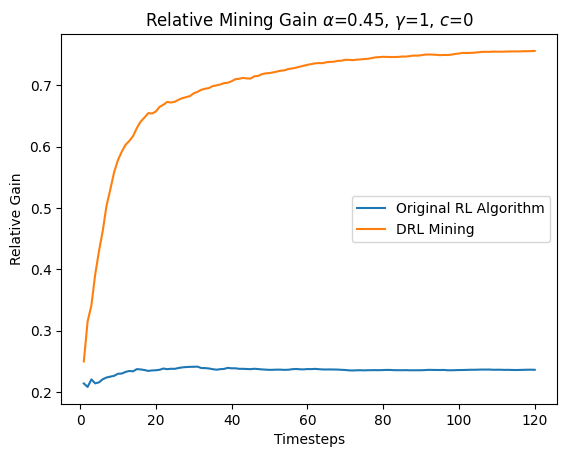

In [9]:
tabular_revenues = np.load('tabular_revenues.npy')
dqn_revenues = np.load('dqn_revenues.npy')

timesteps = np.arange(1, len(tabular_revenues) + 1)
plt.plot(timesteps, tabular_revenues, label='Original RL Algorithm')
plt.plot(timesteps, dqn_revenues[:-1], label='DRL Mining')
plt.legend(loc=0)
plt.xlabel('Timesteps')
plt.ylabel('Relative Gain')
plt.title(r'Relative Mining Gain $\alpha$=0.45, $\gamma$=1, $c$=0')
plt.show()